In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [14]:
def barycenter(components, color):
    i, j = np.where(components==color) # all row and column indexes for the corresponding component
    area = len(i)
    return [np.sum(i)/area, np.sum(j)/area] # barycenter

def covariance(components, color):
    i, j = np.where(components==color)
    return np.cov(i, j, bias=True)

def eigenvalues(cov): # return eigenvalues in ascending order
    return np.linalg.eigvalsh(cov).tolist()

def eigenvector(cov): # ordered respect decreasing eigenvalues, normalised eigenvectors
    eigenval, eigenvect = np.linalg.eig(cov)
    i = 0
    if eigenval[i] < eigenval[i+1]:
        return eigenvect[:, i+1], eigenvect[:, i]
    return eigenvect[:, i], eigenvect[:, i+1]

def orientation(cov):
    eigenvect = eigenvector(cov)
    angle = np.arccos(eigenvect[0][1])*180/np.pi
    if angle > 90: # cos arccos returns between 0 and 180
        return 180 - angle
    return angle
    

def length_width(w, v): # approximation through the eigenvalues 
    return (2* (v**0.5), 2* (w**0.5))


def barycenter_width(contour, barycenter, angle): # width at the barycenter is just to the 2 points in the contours such
                                                  # that distance between each of them with the barycenter is minimal
    min1 = 100
    min2 = 100
    i = 0
    for cont in contour:
        cont = cont[0]
        dist = ((cont[1]-barycenter[0]) ** 2+ (cont[0]-barycenter[1]) ** 2) ** 0.5
        if i % 2 == 0:
            if dist < min1:
                min1 = dist
        else:
            if dist < min2:
                min2 = dist
        i += 1
        
    return min1 + min2

#cv2.CHAIN_APPROX_SIMPLE 4 connected
#cv2.CHAIN_APPROX_NONE   8 connected

In [15]:
def first_task(name, default=False):
    if default:
        img = name
    else:
        img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    filt = cv2.medianBlur(img, 3) #problem with 21 for the shadows, so i filter the image to improve the quality
    retval, threshold = cv2.threshold(filt, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #to have an automatic threshold selection

#     plt.figure(figsize=(5, 5))
#     plt.imshow(threshold ,cmap='gray')
#    plt.show()
#     hist, _  =  np.histogram(img.flatten(), 256, [0,256])
#     plt.plot(hist)
#     plt.show()
   
    type_of_contours = cv2.CHAIN_APPROX_NONE
    contours, _ = cv2.findContours(threshold,cv2.RETR_TREE, type_of_contours)

#     im = np.copy(threshold)
#     cv2.drawContours(im, contours, -1, color=127, thickness=2)
#     plt.figure(figsize=(5, 5))
#     plt.imshow(im, cmap='gray')
#     plt.show()     
  
    d=dict() #key are the pointer to the principal components in contours, while values principal components and its holes
    blob = list()
    rateo = 3
    mod = len(contours[0])
    i = 0
    z = 0
    for contour in contours:
        perim = len(contour)
        if perim >= mod/rateo:
            d[i] = (perim, )
            mod = perim
            z = i
            blob.append(z)
        else:
            d[z] += ((perim, ))
        i += 1
        
    components = np.copy(threshold)
    mul = 1
    for index in range(len(contours)):
        if index in blob:
            cv2.drawContours(components, contours=contours, contourIdx=index, color=255-mul*30-index*10, thickness=cv2.FILLED)
            mul += 1
        else:
            cv2.drawContours(components, contours=contours, contourIdx=index, color=0, thickness=cv2.FILLED)

    mul = 1
    for index in range(len(contours)):
        s = 'A'
        color = 255-mul*30-index*10
        if index in blob:
            if len(d[index])-1 == 2:
                s = 'B'
            print('---------------------------------------------------------------------------')
            print('-The figure with number of grayscale '+str(color)+' is of type '+s)
            cov = covariance(components, color)
            w, v = eigenvalues(cov)
            length, width = length_width(w, v)
            orient = orientation(cov)
            barycent = barycenter(components, color)
            barycent_width = barycenter_width(contours[index], barycent, orient)
            print('It has:')
            print()
            print('Length = ' + str(length))
            print('Width = ' + str(width))
            print('Width at the barycenter = ' + str(barycent_width))
            print('Orientation = ' + str(orient))
            mul+=1
        else:
            print()
            diameter = len(contours[index]) / np.pi
            comp_copy = np.copy(components)
            cv2.drawContours(comp_copy, contours=contours, contourIdx=index, color=10, thickness=cv2.FILLED)
            center = barycenter(comp_copy, 10)
            print('Its hole of diameter ' + str(diameter) + ' has the center in ' + str(center))
    
    print('---------------------------------------------------------------------------')
    plt.figure(figsize=(5, 5))
    plt.imshow(components, cmap='gray')
    plt.show()

In [21]:
def second_task(name): # The inspection area may be dirty due to the presence of scattered iron powder
    source = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    filt = cv2.medianBlur(source, 3)
    for i in range(2):
        filt = cv2.medianBlur(filt, 3)

#     plt.figure(figsize=(10, 10))
#     plt.subplot(1, 2, 1)
#     plt.imshow(source,cmap='gray')
#     plt.subplot(1, 2, 2)
#     plt.imshow(filt, cmap='gray')
#     plt.show()
#     hist, _  = np.histogram(filt.flatten(), 256, [0,256])
#     plt.plot(hist)
#     plt.show()
   
    first_task(filt, True)

---------------------------------------------------------------------------
-The figure with number of grayscale 225 is of type A
It has:

Length = 108.03427851959842
Width = 15.189303307344069
Width at the barycenter = 13.859096519176742
Orientation = 85.98712967033767

Its hole of diameter 21.008452488130185 has the center in [199.94026548672565, 50.966814159292035]
---------------------------------------------------------------------------
-The figure with number of grayscale 175 is of type B
It has:

Length = 62.46022284142597
Width = 11.43022463687169
Width at the barycenter = 12.978068633115829
Orientation = 83.47958970348152

Its hole of diameter 22.91831180523293 has the center in [158.97378277153558, 109.95880149812734]

Its hole of diameter 19.735212943395023 has the center in [60.363861386138616, 121.13613861386139]
---------------------------------------------------------------------------
-The figure with number of grayscale 115 is of type A
It has:

Length = 102.348209704

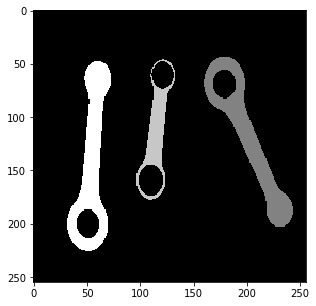

In [18]:
name1 = '/images/TESI00.BMP'
first_task(name1)

---------------------------------------------------------------------------
-The figure with number of grayscale 225 is of type B
It has:

Length = 61.37366656364926
Width = 14.460593626073107
Width at the barycenter = 15.892377261698597
Orientation = 51.88077465650016

Its hole of diameter 21.326762374313976 has the center in [184.68134171907758, 113.79035639412997]

Its hole of diameter 24.50986123615188 has the center in [109.66499162479062, 54.17922948073702]
---------------------------------------------------------------------------
-The figure with number of grayscale 165 is of type A
It has:

Length = 101.12553613197625
Width = 19.42899776477127
Width at the barycenter = 18.316781260509615
Orientation = 45.10926928330462

Its hole of diameter 22.91831180523293 has the center in [74.87174721189591, 121.09851301115242]
---------------------------------------------------------------------------


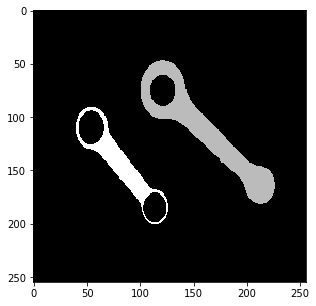

In [19]:
name2 = '.images//TESI90.BMP'
second_task(name2)